# Identifying Enron fraud
--- 

This document reports the process of building a classifier to identify people that commited fraud at Enron.

- Exploration
- Feature selection

# Exploration

---

The usual imports:

In [22]:
import pickle
import pandas as pd
import sys
from pprint import pprint
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
%matplotlib inline
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

features_list = ['poi', 'bonus', 'director_fees', 'exercised_stock_options',
                 'total_payments', 'total_stock_value', 'long_term_incentive',
                 'salary']  # You will need to use more features

Open dataset and convert to DataFrame for easy exploration in jupyter notebook:

In [12]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict).T

df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


In [33]:
(df.apply(lambda x: x.str.contains('NaN'))
   .fillna(False)
   .sum()
   .sort_values()
   )

poi                            0.0
total_stock_value             20.0
total_payments                21.0
email_address                 35.0
restricted_stock              36.0
exercised_stock_options       44.0
salary                        51.0
expenses                      51.0
other                         53.0
to_messages                   60.0
shared_receipt_with_poi       60.0
from_messages                 60.0
from_poi_to_this_person       60.0
from_this_person_to_poi       60.0
bonus                         64.0
long_term_incentive           80.0
deferred_income               97.0
deferral_payments            107.0
restricted_stock_deferred    128.0
director_fees                129.0
loan_advances                142.0
dtype: float64

In [34]:
len(df)

146

In [3]:
data_dict['TOTAL']

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

First I am trying to understand all features and their meaning. These are the features I think I understand:

Related to financials (in USD):
- **bonus**: financial bonus received by this person
- **salary**: yearly salary received by this person
- **total_stock_value**: total value of the stocks owned by this person
- **total_payments**: sum of all payments by Enron to this person
- **expenses**: the expenses done by Enron for this person
- **director_fees**: the fees received by this person because he/she is a director
- **exercised_stock_options**: stock options that were traded for money before Enron's bankruptcy
- **long_term_incentive**: some kind of bonus that is paid for achieving long term results

Related to emails:
- **email_address**: the person's email address
- **from_messages**: the amount of email messages sent by this person
- **to_messages**: the amount of email messages received by this person
- **from_poi_to_this_person**: the amount of email messages from a person of interest to this person
- **from_this_person_to_poi**: the amount of email messages from this person to a person of interest

Related to persons of interest:
- **poi**: flag to identify whether a person is a person of interest. E.g. because of lawsuits etc.

And the ones that I don't quite get:
- deferral_payments
- deferred_income
- loan_advances
- other
- restricted_stock
- restricted_stock_deferred
- shared_receipt_with_poi 

In [4]:
df_data = pd.DataFrame.from_dict(data_dict, orient='index')

In [5]:
pprint(df_data.columns.values.tolist())

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']


### Cast numeric columns to float

In [6]:
numeric_columns = ['salary',
                   'to_messages',
                   'deferral_payments',
                   'total_payments',
                   'exercised_stock_options',
                   'bonus',
                   'restricted_stock',
                   'shared_receipt_with_poi',
                   'restricted_stock_deferred',
                   'total_stock_value',
                   'expenses',
                   'loan_advances',
                   'from_messages',
                   'other',
                   'from_this_person_to_poi',
                   'director_fees',
                   'deferred_income',
                   'long_term_incentive',
                   'from_poi_to_this_person']

df_data[numeric_columns] = df_data[numeric_columns].astype(float)

## Detecting outliers

### Salary

Looks like an outlier with a salary of around 2.7 billion USD. Let's find out who this is:

In [7]:
df_data.loc[(df_data.salary > 2.5e7) & (df_data.salary != np.nan)]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
TOTAL,26704229.0,NaN,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,NaN,-7576788.0,434509511.0,...,83925000.0,NaN,42667589.0,NaN,False,1398517.0,-27992891.0,48521928.0,NaN,NaN


That explains it: apparently there is an entry for the total amount of money paid to all employees. Let's remove it and see what the histogram looks like:

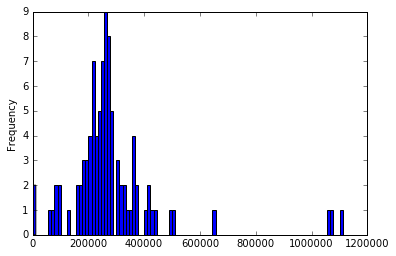

In [8]:
outliers = ['TOTAL']

df_data = df_data.drop('TOTAL')
df_data.salary.plot.hist(bins=100)

Looks like there are also some people with a salary of zero. What about them?

In [9]:
df_data.loc[df_data.salary < 1000]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,NaN,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,james.bannantine@enron.com,39.0


Cannot find them. But this guy also looks like an outlier. A salary of 477 USD, with a total stock value of 5.2 mln USD sounds strange. I suspect that it should be 477e3 dollar, but I am not sure. That's why I will leave it out. I'll collect the names in a list to be removed later.

In [10]:
outliers.append('BANNANTINE JAMES M')

And let's find out who these people are that earn more than 1 mln USD:

In [11]:
df_data.loc[(df_data.salary > 1e6)]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
FREVERT MARK A,1060932.0,3275.0,6426990.0,17252530.0,10433518.0,2000000.0,4188667.0,2979.0,NaN,14622185.0,...,2000000.0,21.0,7427621.0,6.0,False,NaN,-3367011.0,1617011.0,mark.frevert@enron.com,242.0
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,NaN,49110078.0,...,81525000.0,36.0,10359729.0,16.0,True,NaN,-300000.0,3600000.0,kenneth.lay@enron.com,123.0
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,19250000.0,5600000.0,6843672.0,2042.0,NaN,26093672.0,...,NaN,108.0,22122.0,30.0,True,NaN,NaN,1920000.0,jeff.skilling@enron.com,88.0


Frevert, Lay, and Skilling were all executives at enron, so I'll trust this.

### Bonus

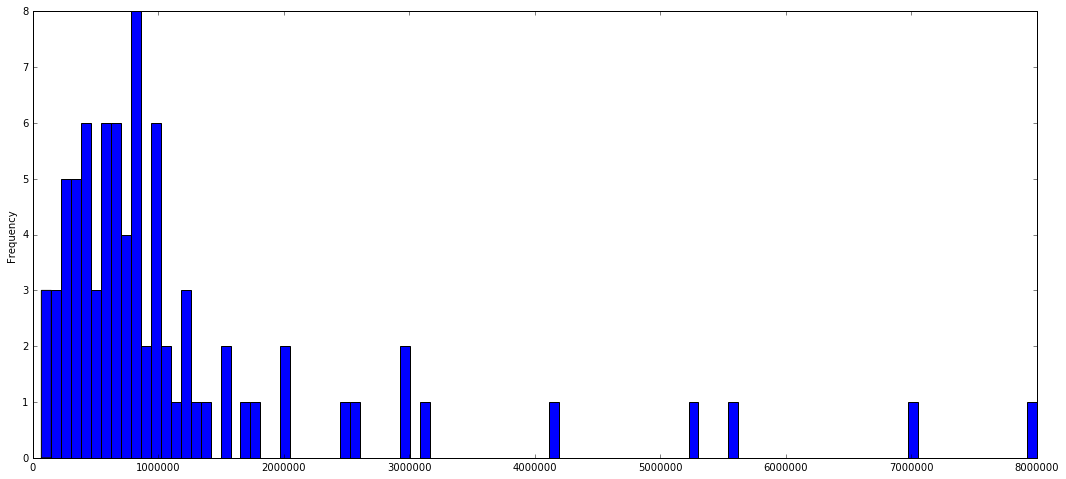

In [12]:
df_data.bonus.plot.hist(bins=100, figsize=(18,8))

In [13]:
df_data.loc[df_data.bonus > 4e6, 'bonus']

ALLEN PHILLIP K       4175000.0
BELDEN TIMOTHY N      5249999.0
LAVORATO JOHN J       8000000.0
LAY KENNETH L         7000000.0
SKILLING JEFFREY K    5600000.0
Name: bonus, dtype: float64

### Excercised stock options

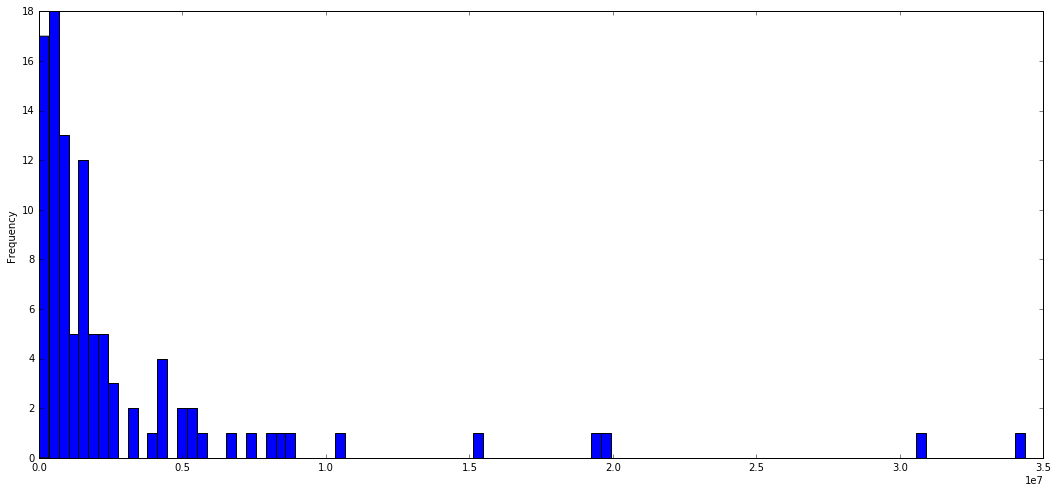

In [14]:
df_data.exercised_stock_options.plot.hist(bins=100, figsize=(18,8))

In [15]:
df_data.loc[df_data.exercised_stock_options > 1e7, 'exercised_stock_options']

FREVERT MARK A        10433518.0
HIRKO JOSEPH          30766064.0
LAY KENNETH L         34348384.0
PAI LOU L             15364167.0
RICE KENNETH D        19794175.0
SKILLING JEFFREY K    19250000.0
Name: exercised_stock_options, dtype: float64

Some research in the people found so far: 

- **Mark Frevert**: Enron Wholesale Services
- **Hirko Joseph**: CFO FirstPoint communications, later part of broadband division
- **Lou Pai**: CEO Enron Energy Services
- **Kenneth Rice**: CEO of broadband division

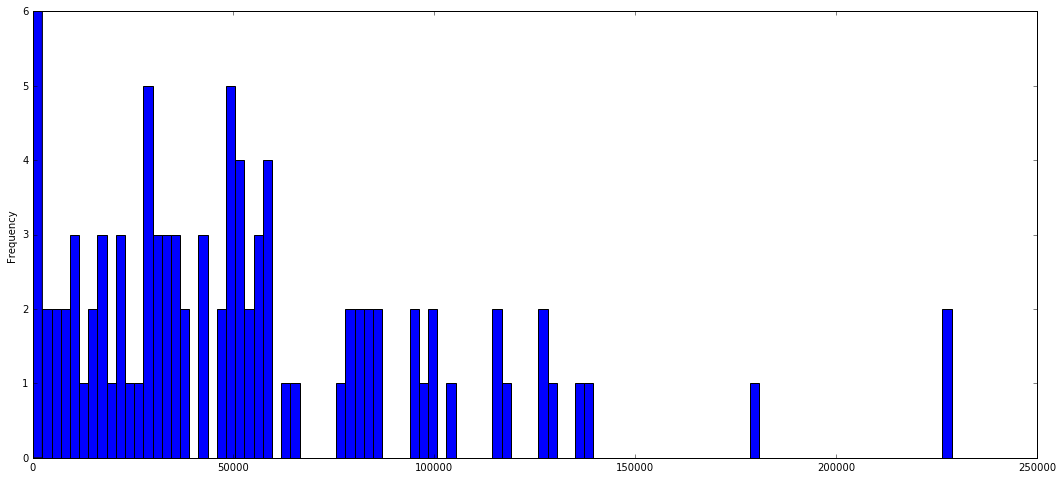

In [16]:
df_data.expenses.plot.hist(bins=100, figsize=(18,8))

In [17]:
df_data.loc[df_data.expenses > 1.5e5]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
MCCLELLAN GEORGE,263413.0,1744.0,NaN,1318763.0,506765.0,900000.0,441096.0,1469.0,NaN,947861.0,...,NaN,49.0,51587.0,0.0,False,NaN,-125000.0,NaN,george.mcclellan@enron.com,52.0
SHANKMAN JEFFREY A,304110.0,3221.0,NaN,3038702.0,1441898.0,2000000.0,630137.0,1730.0,NaN,2072035.0,...,NaN,2681.0,1191.0,83.0,False,NaN,NaN,554422.0,jeffrey.shankman@enron.com,94.0
URQUHART JOHN A,NaN,NaN,NaN,228656.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,36666.0,-36666.0,NaN,NaN,NaN


### Total payments

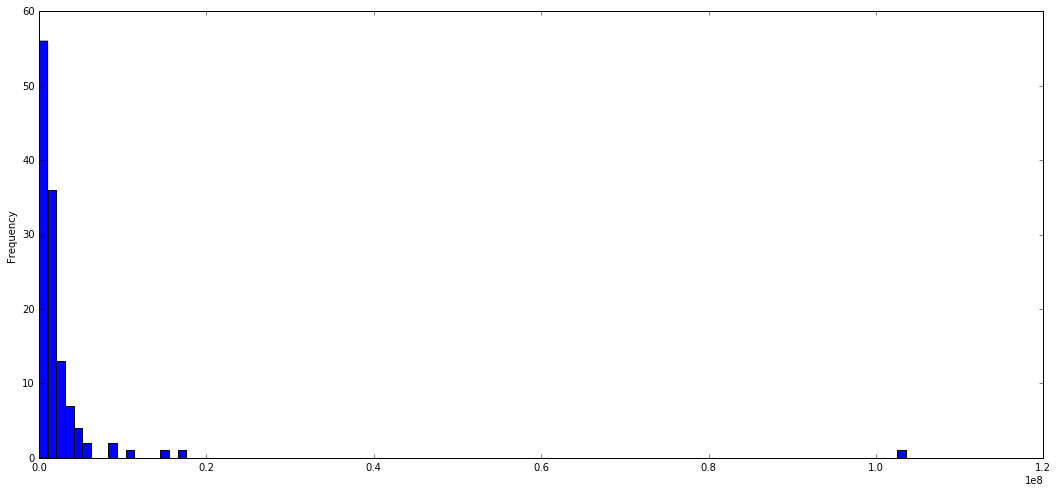

In [18]:
df_data.total_payments.plot.hist(bins=100, figsize=(18,8))

In [19]:
df_data.total_payments.loc[df_data.total_payments > 0.05e8]

BAXTER JOHN C           5634343.0
BELDEN TIMOTHY N        5501630.0
BHATNAGAR SANJAY       15456290.0
FREVERT MARK A         17252530.0
LAVORATO JOHN J        10425757.0
LAY KENNETH L         103559793.0
MARTIN AMANDA K         8407016.0
SKILLING JEFFREY K      8682716.0
Name: total_payments, dtype: float64

In [20]:
df_data.loc[df_data.total_payments < 1000]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
HAUG DAVID L,NaN,573.0,NaN,475.0,NaN,NaN,2217299.0,471.0,NaN,2217299.0,...,NaN,19.0,NaN,7.0,False,NaN,NaN,NaN,david.haug@enron.com,4.0
MENDELSOHN JOHN,NaN,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,103750.0,-103750.0,NaN,NaN,NaN


### Total stock value

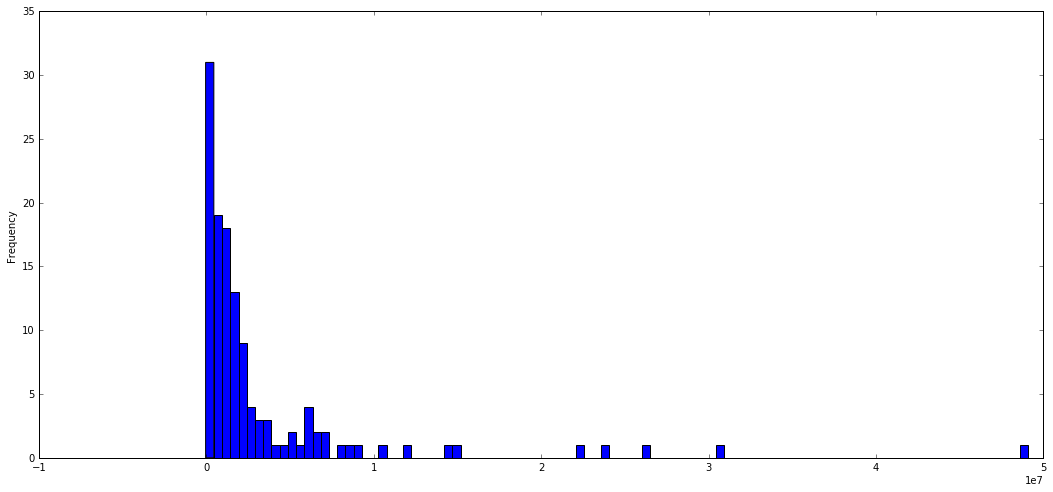

In [21]:
df_data.total_stock_value.plot.hist(bins=100, figsize=(18,8))

In [22]:
df_data.total_stock_value.loc[df_data.total_stock_value > 1.0e7]

BAXTER JOHN C         10623258.0
FREVERT MARK A        14622185.0
HIRKO JOSEPH          30766064.0
LAY KENNETH L         49110078.0
PAI LOU L             23817930.0
RICE KENNETH D        22542539.0
SKILLING JEFFREY K    26093672.0
WHITE JR THOMAS E     15144123.0
YEAGER F SCOTT        11884758.0
Name: total_stock_value, dtype: float64

### Long term incentive

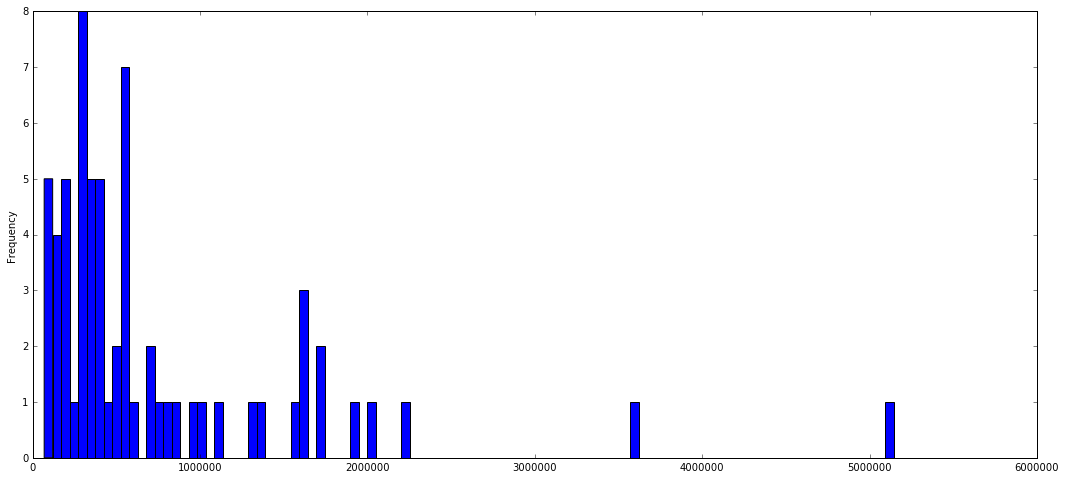

In [23]:
df_data.long_term_incentive.plot.hist(bins=100, figsize=(18,8))

In [24]:
df_data.long_term_incentive.loc[df_data.long_term_incentive > 1.0e6]

BAXTER JOHN C         1586055.0
DELAINEY DAVID W      1294981.0
DURAN WILLIAM D       1105218.0
ECHOLS JOHN B         2234774.0
FASTOW ANDREW S       1736055.0
FREVERT MARK A        1617011.0
HANNON KEVIN P        1617011.0
LAVORATO JOHN J       2035380.0
LAY KENNETH L         3600000.0
LEFF DANIEL P         1387399.0
MARTIN AMANDA K       5145434.0
MULLER MARK S         1725545.0
RICE KENNETH D        1617011.0
SKILLING JEFFREY K    1920000.0
Name: long_term_incentive, dtype: float64

### Persons of interest

In [25]:
pprint(df_data.loc[df_data.poi==1].index)

Index([u'BELDEN TIMOTHY N', u'BOWEN JR RAYMOND M', u'CALGER CHRISTOPHER F',
       u'CAUSEY RICHARD A', u'COLWELL WESLEY', u'DELAINEY DAVID W',
       u'FASTOW ANDREW S', u'GLISAN JR BEN F', u'HANNON KEVIN P',
       u'HIRKO JOSEPH', u'KOENIG MARK E', u'KOPPER MICHAEL J',
       u'LAY KENNETH L', u'RICE KENNETH D', u'RIEKER PAULA H', u'SHELBY REX',
       u'SKILLING JEFFREY K', u'YEAGER F SCOTT'],
      dtype='object')


### Director fees

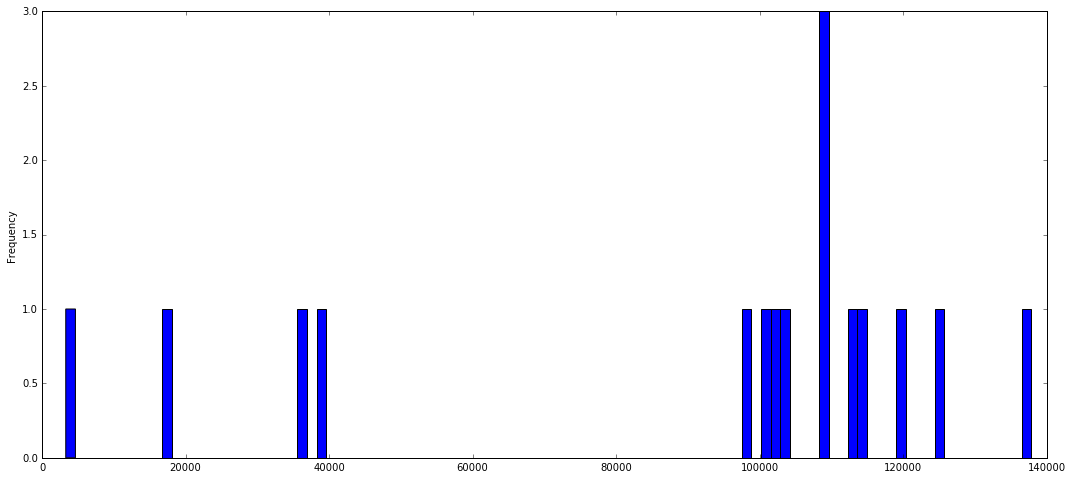

In [26]:
df_data.director_fees.plot.hist(bins=100, figsize=(18,8))

In [27]:
len(df_data.loc[~df_data.director_fees.isnull()])

16

### to_messages

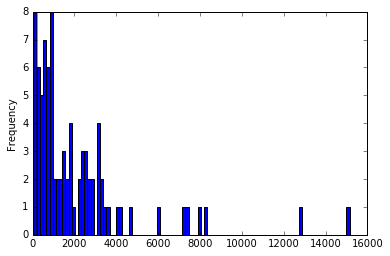

In [28]:
df_data.to_messages.plot.hist(bins=100)

In [29]:
df_data.loc[df_data.to_messages > 1.0e4]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
KEAN STEVEN J,404338.0,12754.0,NaN,1747522.0,2022048.0,1000000.0,4131594.0,3639.0,NaN,6153642.0,...,NaN,6759.0,1231.0,387.0,False,NaN,NaN,300000.0,steven.kean@enron.com,140.0
SHAPIRO RICHARD S,269076.0,15149.0,NaN,1057548.0,607837.0,650000.0,379164.0,4527.0,NaN,987001.0,...,NaN,1215.0,705.0,65.0,False,NaN,NaN,NaN,richard.shapiro@enron.com,74.0


### from_messages

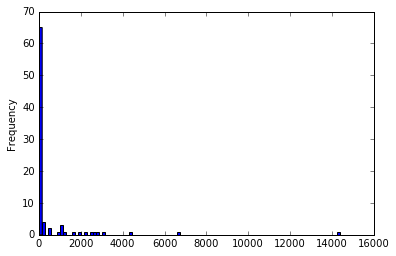

In [30]:
df_data.from_messages.plot.hist(bins=100)

In [31]:
df_data.loc[df_data.from_messages>1.4e4]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
KAMINSKI WINCENTY J,275101.0,4607.0,NaN,1086821.0,850010.0,400000.0,126027.0,583.0,NaN,976037.0,...,NaN,14368.0,4669.0,171.0,False,NaN,NaN,323466.0,vince.kaminski@enron.com,41.0


### from poi to this person

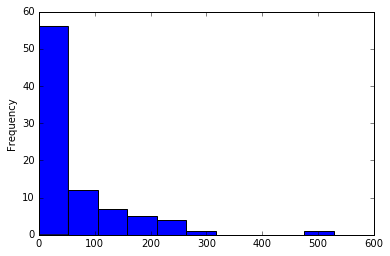

In [32]:
df_data.from_poi_to_this_person.plot.hist()

### from this person to poi

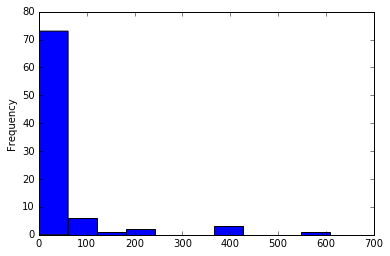

In [33]:
df_data.from_this_person_to_poi.plot.hist()

In [34]:
df_data.to_dict(orient='index')

{'ALLEN PHILLIP K': {'bonus': 4175000.0,
  'deferral_payments': 2869717.0,
  'deferred_income': -3081055.0,
  'director_fees': nan,
  'email_address': 'phillip.allen@enron.com',
  'exercised_stock_options': 1729541.0,
  'expenses': 13868.0,
  'from_messages': 2195.0,
  'from_poi_to_this_person': 47.0,
  'from_this_person_to_poi': 65.0,
  'loan_advances': nan,
  'long_term_incentive': 304805.0,
  'other': 152.0,
  'poi': False,
  'restricted_stock': 126027.0,
  'restricted_stock_deferred': -126027.0,
  'salary': 201955.0,
  'shared_receipt_with_poi': 1407.0,
  'to_messages': 2902.0,
  'total_payments': 4484442.0,
  'total_stock_value': 1729541.0},
 'BADUM JAMES P': {'bonus': nan,
  'deferral_payments': 178980.0,
  'deferred_income': nan,
  'director_fees': nan,
  'email_address': 'NaN',
  'exercised_stock_options': 257817.0,
  'expenses': 3486.0,
  'from_messages': nan,
  'from_poi_to_this_person': nan,
  'from_this_person_to_poi': nan,
  'loan_advances': nan,
  'long_term_incentive': n

In [35]:
(df_data.from_this_person_to_poi/df_data.from_messages).sort_values()

MEYER ROCKFORD G                 0.000000
HAYES ROBERT E                   0.000000
FOY JOE                          0.000000
FOWLER PEGGY                     0.000000
LEWIS RICHARD                    0.000000
MARTIN AMANDA K                  0.000000
MCCLELLAN GEORGE                 0.000000
CORDES WILLIAM R                 0.000000
MORAN MICHAEL P                  0.000000
MULLER MARK S                    0.000000
PICKERING MARK R                 0.000000
GIBBS DANA R                     0.000000
BUCHANAN HAROLD G                0.000000
BANNANTINE JAMES M               0.000000
WALLS JR ROBERT H                0.000000
TAYLOR MITCHELL S                0.000000
UMANOFF ADAM S                   0.000000
THORN TERENCE H                  0.000000
POWERS WILLIAM                   0.000000
BERGSIEKER RICHARD P             0.000000
MCCARTY DANNY J                  0.009302
KAMINSKI WINCENTY J              0.011901
HORTON STANLEY C                 0.013979
DERRICK JR. JAMES V              0

In [36]:
df_data.loc[['HUMPHREY GENE E',
            'SHERRICK JEFFREY B',
            'HANNON KEVIN P',
            'GARLAND C KEVIN']]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
HUMPHREY GENE E,130724.0,128.0,2964506.0,3100224.0,2282768.0,NaN,NaN,119.0,NaN,2282768.0,...,NaN,17.0,NaN,17.0,False,NaN,NaN,NaN,gene.humphrey@enron.com,10.0
SHERRICK JEFFREY B,NaN,613.0,NaN,NaN,1426469.0,NaN,405999.0,583.0,NaN,1832468.0,...,NaN,25.0,NaN,18.0,False,NaN,NaN,NaN,jeffrey.sherrick@enron.com,39.0
HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,5538001.0,1500000.0,853064.0,1035.0,NaN,6391065.0,...,NaN,32.0,11350.0,21.0,True,NaN,-3117011.0,1617011.0,kevin.hannon@enron.com,32.0
GARLAND C KEVIN,231946.0,209.0,NaN,1566469.0,636246.0,850000.0,259907.0,178.0,NaN,896153.0,...,NaN,44.0,60814.0,27.0,False,NaN,NaN,375304.0,kevin.garland@enron.com,10.0


In [37]:
df_data.loc['THE TRAVEL AGENCY IN THE PARK']

salary                          NaN
to_messages                     NaN
deferral_payments               NaN
total_payments               362096
exercised_stock_options         NaN
bonus                           NaN
restricted_stock                NaN
shared_receipt_with_poi         NaN
restricted_stock_deferred       NaN
total_stock_value               NaN
expenses                        NaN
loan_advances                   NaN
from_messages                   NaN
other                        362096
from_this_person_to_poi         NaN
poi                           False
director_fees                   NaN
deferred_income                 NaN
long_term_incentive             NaN
email_address                   NaN
from_poi_to_this_person         NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

In [38]:
df_data.loc[df_data.salary.isnull()]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BELFER ROBERT,NaN,NaN,-102500.0,102500.0,3285.0,NaN,NaN,NaN,44093.0,-44093.0,...,NaN,NaN,NaN,NaN,False,3285.0,NaN,NaN,NaN,NaN
BHATNAGAR SANJAY,NaN,523.0,NaN,15456290.0,2604490.0,NaN,-2604490.0,463.0,15456290.0,NaN,...,NaN,29.0,137864.0,1.0,False,137864.0,NaN,NaN,sanjay.bhatnagar@enron.com,0.0
BLAKE JR. NORMAN P,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,113784.0,-113784.0,NaN,NaN,NaN
BROWN MICHAEL,NaN,1486.0,NaN,49288.0,NaN,NaN,NaN,761.0,NaN,NaN,...,NaN,41.0,NaN,1.0,False,NaN,NaN,NaN,michael.brown@enron.com,13.0
CHAN RONNIE,NaN,NaN,NaN,NaN,NaN,NaN,32460.0,NaN,-32460.0,NaN,...,NaN,NaN,NaN,NaN,False,98784.0,-98784.0,NaN,NaN,NaN
CHRISTODOULOU DIOMEDES,NaN,NaN,NaN,NaN,5127155.0,NaN,950730.0,NaN,NaN,6077885.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,diomedes.christodoulou@enron.com,NaN
CLINE KENNETH W,NaN,NaN,NaN,NaN,NaN,NaN,662086.0,NaN,-472568.0,189518.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
CORDES WILLIAM R,NaN,764.0,NaN,NaN,651850.0,NaN,386335.0,58.0,NaN,1038185.0,...,NaN,12.0,NaN,0.0,False,NaN,NaN,NaN,bill.cordes@enron.com,10.0
DUNCAN JOHN H,NaN,NaN,NaN,77492.0,371750.0,NaN,NaN,NaN,NaN,371750.0,...,NaN,NaN,NaN,NaN,False,102492.0,-25000.0,NaN,NaN,NaN


# Feature selection

Criteria for initial selection
- Feature must be filled. I will only take into account features for which more than half of the values is not NaN.
- Feature must not be related to another feature. 
- Based on common sense, the feature must be able to describe a POI. (i.e. exclude email adress).

In [71]:
for column in df_data.columns:
    null_count = sum(df_data[column].isnull())
    non_null_count = len(df_data) - null_count
    fill_percentage = float(non_null_count)/float(len(df_data))
    
    if fill_percentage > 0.5: 
        print column

salary
to_messages
total_payments
exercised_stock_options
bonus
restricted_stock
shared_receipt_with_poi
total_stock_value
expenses
from_messages
other
from_this_person_to_poi
poi
email_address
from_poi_to_this_person


Exclusing email_adress (not descriptive) and poi (target feature), leaves us with 13 features to consider.

Next question is: how to tackle NaN values. There are at several options:
1. Exclude entries for which one of the features is NaN.
2. Fill NaN values with 0
3. Fill NaN values with a summary statistic of that feature. E.g. the mean or the median.

The method for dealing with NaNs varies for financial data an email data. For financial data, a NaN value simply means zero. For email data, it means that data is not available. 

In [76]:
email_features = ['to_messages',
                  'shared_receipt_with_poi',
                  'from_messages',
                  'from_this_person_to_poi',
                  'from_poi_to_this_person',
                  'email_address']

financial_features = ['salary',
                      'deferral_payments',
                      'total_payments',
                      'exercised_stock_options',
                      'bonus',
                      'restricted_stock',
                      'restricted_stock_deferred',
                      'total_stock_value',
                      'expenses',
                      'loan_advances',
                      'other',
                      'director_fees',
                      'deferred_income',
                      'long_term_incentive']

In [79]:
df_data.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,NaN,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,NaN,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,...,NaN,NaN,2660303.0,NaN,False,NaN,-1386055.0,1586055.0,NaN,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,63014.0,...,NaN,NaN,69.0,NaN,False,NaN,-201641.0,NaN,frank.bay@enron.com,NaN


In [80]:
df_data[financial_features] = df_data[financial_features].fillna(0)

In [81]:
df_data.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,0.0,NaN,178980.0,182466.0,257817.0,0.0,0.0,NaN,0.0,257817.0,...,0.0,NaN,0.0,NaN,False,0.0,0.0,0.0,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,0.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,0.0,10623258.0,...,0.0,NaN,2660303.0,NaN,False,0.0,-1386055.0,1586055.0,NaN,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,0.0,400000.0,145796.0,NaN,-82782.0,63014.0,...,0.0,NaN,69.0,NaN,False,0.0,-201641.0,0.0,frank.bay@enron.com,NaN
